Simple WOFS example Notebook

### Loads WOFS data from the data cube. Created by Vanessa Newey

In [43]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#dealing with system commands
import sys
import os.path

import matplotlib.pyplot as plt

from IPython.display import display
import ipywidgets as widgets
#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

In [44]:
def load_wofs(query):
    
    #Create a query to store spatiotemporal information from the previous landsat query
    wofs_query = query
    dcwofs = datacube.Datacube(config='/g/data/r78/dc_configs/wofscube.conf')
    
    wofs_data = dcwofs.load(product = 'wofs_albers', **wofs_query)

    return wofs_data

## Enter input shapefile and start and end date

In [45]:
#code to work with a polygon input
shape_file = ('/g/data/r78/vmn547/GWandDEA_bex_ness/Little_GW_AOI_for_demo/kEEP_ord/KEEP_AOI.shp')

In [46]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range
start_of_epoch = '2011-01-01'
end_of_epoch =  '2011-12-31'


In [47]:
if True:
    shapes = fiona.open(shape_file)
    #i is the index of the shape file we have chosen
    i =0 
    #copy attributes from shapefile and define shape_name
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    
    query = {
        'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom
    }
    
    # an alternative simple query 
   
    query2 = {'time': (start_of_epoch, end_of_epoch)}
    lat_max = -17.42
    lat_min = -17.45
    lon_max = 140.90522
    lon_min = 140.8785

    query2['x'] = (lon_min, lon_max)
    query2['y'] = (lat_max, lat_min)
    query2['crs'] = 'EPSG:4326'
    #load wofs data (see function above)
    wofs_data = load_wofs(query)



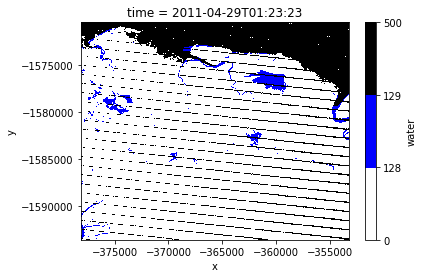

In [48]:
import matplotlib as mpl
wofs_cmap = mpl.colors.ListedColormap(['#ffffff','#0000ff','#000000'])
wofs_data.water.isel(time=5).plot(levels=[0,128,129,500],cmap=wofs_cmap)
plt.show()


In [49]:
#Remove all values that are not defined as "wet water" (value of 128)
wofs128=wofs_data
wofs128['water']=wofs_data.water.where(wofs_data.water==128)

#Add water values for each pixel and turn into a percentage

#Add the water value for each pixel in the array over time
wofs128_v2 = wofs128.sum(dim = 'time')

#Take the average of water value at each pixel and turn into a percentage
wofs128_v2 = wofs128_v2/ 128
wofs128_v2 = wofs128_v2 / len(wofs128.time)
wofs128_v2 = wofs128_v2*100


In [50]:
#Set up the WOfS colour ramp and corresponding thresholds
wofs_cmap = mpl.colors.ListedColormap(['#C8B97D','#B3E5FC','#81D4FA','#4FC3F7','#29B6F6','#039BE5',
                                       '#0288D1','#0277BD', '#01579B','#1A237E','#02033a','#5e0799'])##User should format as required
wofs_bounds = [0.1,0.1,5,10,20,30,40,50,60,70,80,90,100] ##User should format as required
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/matplotlib/colorbar.py:888: RuntimeWarning: invalid value encountered in true_divide
  z = np.take(y, i0) + (xn - np.take(b, i0)) * dy / db


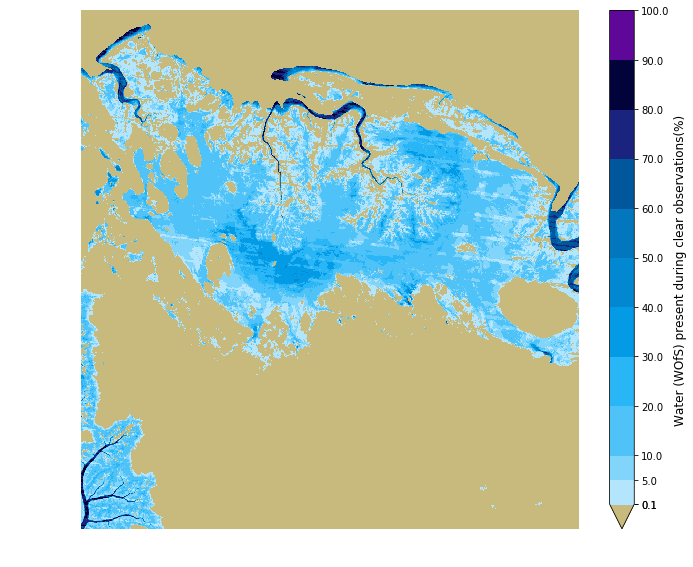

HTML(value='Event information appears here when you click on the figure')

In [52]:
#Create a WOfS image for the specified percentage exceedance range of interest. 
#The image shows the percentage of time each pixel contains water during the specified range of interest

#Create widget that enables interaction with plot.
w = widgets.HTML("Event information appears here when you click on the figure")

#Create image
fig = plt.figure(figsize =(12,8)) #Set figure size ##User should format if required
i= wofs128_v2.water.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)#create WOfS image

def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y) 
fig.canvas.mpl_connect('button_press_event', callback)

#Format image
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar
fig.colorbar(i, ticks=wofs_bounds, spacing='proportional', 
             extend='min').set_label(label='Water (WOfS) present during clear observations(%)',
             size=12) #Add definable colour bar
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border size
fig.patch.set_facecolor('white') #Ensure border is white
fig.patch.set_alpha(0.99) #Ensure border is white
plt.axis('off') #Remove axis

plt.show() #Create image
display(w) #Create image